In [1]:
import tensorflow as tf
import numpy as np
#import mnist_handler
import os
import pandas as pd
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="3"; 
INPUT_DIMENSION = 100
NUM_CLASSES = 2

train_hill_data = pd.read_csv("UCI dataset/Hill_Valley_with_noise_Training.csv")
test_hill_data = pd.read_csv("UCI dataset/Hill_Valley_with_noise_Testing.csv")

x_train = train_hill_data.iloc[:,0:100]
y_train = train_hill_data.iloc[:,100]

x_test = test_hill_data.iloc[:,0:100]
y_test = test_hill_data.iloc[:,100]
x_train = np.array(x_train)
x_test = np.array(x_test)
data = np.concatenate((x_train,x_test),axis = 0)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape,data.shape)

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(606, 100) (606, 100) (606,) (606,) (1212, 100)


In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)
print(data)

[[3.23410461e-04 3.26826856e-04 3.13785122e-04 ... 3.31526542e-04
  3.22973439e-04 3.33616018e-04]
 [7.72450182e-06 7.43831843e-06 7.72911145e-06 ... 7.90166888e-06
  7.41453098e-06 6.98489438e-06]
 [5.78716027e-01 6.07348067e-01 6.13128820e-01 ... 6.10342597e-01
  5.94957501e-01 6.54129683e-01]
 ...
 [8.62404977e-02 8.30862924e-02 7.55612217e-02 ... 8.90258702e-02
  7.94121866e-02 8.12420050e-02]
 [2.87674029e-04 3.13786841e-04 2.86733232e-04 ... 2.71662812e-04
  2.81752177e-04 2.96246833e-04]
 [7.20544077e-02 7.04535483e-02 7.67138675e-02 ... 7.45382462e-02
  7.40429187e-02 7.60647140e-02]]


In [4]:
x_train = data[0:606,:]
x_test = data[606:,:]
x_test.shape
n_input_nodes = 100
n_output_nodes = 100
n_hidden_nodes = 2
y_train.shape


(606,)

In [5]:
import time
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()

	"""BP autoencoder"""
	X = tf.placeholder(tf.float32, [None, n_input_nodes])
	Y = tf.placeholder(tf.float32, [None, n_output_nodes])

	encoding_layer = tf.layers.dense(inputs=X,units=n_hidden_nodes,activation=tf.math.sin)
	Y_hat = tf.layers.dense(inputs=encoding_layer,units=n_output_nodes,activation=None)

	loss = tf.losses.mean_squared_error(labels=Y,predictions=Y_hat)

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	t1 = time.time()
	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train):
			try:
				batch_x = x_train[i:i+BATCH_SIZE]
				batch_y = x_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train[i:]
				batch_y = x_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})
	t2 = time.time()
	time_sum+=(t2-t1)

	"""classification"""
	x_train_encoded = sess.run(encoding_layer, feed_dict={X: x_train})
	x_test_encoded = sess.run(encoding_layer, feed_dict={X: x_test})

	X = tf.placeholder(tf.float32, [None, n_hidden_nodes])
	Y = tf.placeholder(tf.int64, [None])
	Y_ = tf.one_hot(indices=Y, depth=2) # one_hot labels: [N,M]

	fc1 = tf.layers.dense(inputs=X,units=512,activation=tf.nn.relu)
	fc2 = tf.layers.dense(inputs=fc1,units=512,activation=tf.nn.relu)
	out = tf.layers.dense(inputs=fc2,units=2,activation=None)

	loss = tf.losses.softmax_cross_entropy(logits=out,onehot_labels=Y_)
	accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out,axis=1),tf.argmax(Y_,axis=1)),dtype=tf.float32))

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train_encoded):
			try:
				batch_x = x_train_encoded[i:i+BATCH_SIZE]
				batch_y = y_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train_encoded[i:]
				batch_y = y_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})

	"""evaluation"""
	avg_testing_acc = sess.run(accuracy, feed_dict={X: x_test_encoded, Y: y_test})
	print("Testing accuracy: ",avg_testing_acc)
	accuracy_sum+=avg_testing_acc

print("==========================================")
print("BP	 ===================================")
print("==========================================")
print("Average time: ", time_sum/10.0)
print("Average accuracy: ", accuracy_sum/10.0)
print("==========================================")

Testing accuracy:  0.5280528
Testing accuracy:  0.5132013
Testing accuracy:  0.5132013
Testing accuracy:  0.52640265
Testing accuracy:  0.5247525
Testing accuracy:  0.519802
Testing accuracy:  0.5247525
Testing accuracy:  0.50825083
Testing accuracy:  0.5247525
Testing accuracy:  0.5330033
BP	 ===================================
Average time:  0.8238993644714355
Average accuracy:  0.5216171622276307


np.savetxt("hillx_train.csv", x_train, delimiter=",")
np.savetxt("hillyt_train.csv", y_train, delimiter=",")
np.savetxt("hillx_test.csv", x_test, delimiter=",")
np.savetxt("hilly_test.csv", y_test, delimiter=",")

In [4]:

border = 106
x_train_init = x_train[:border]
y_train_init = y_train[:border]
x_train_seq = x_train[border:]
y_train_seq = y_train[border:]

In [5]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X_ = tf.placeholder(tf.float32, [None, INPUT_DIMENSION])
#X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(-5))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [6]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [7]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

# Initial Training

In [8]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init



In [9]:
beta_1_init

<tf.Tensor 'Assign_3:0' shape=(2, 2) dtype=float32_ref>

In [10]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [11]:

'''With one subnetwork'''
logits_init = subnet_output(alpha_1, beta_1, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [12]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
"""Initial training"""
sess.run(E_1_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.47783542
Initial train training accuracy:  0.49339935
Initial train testing loss:  0.47645548
Initial train testing accuracy:  0.5066007


In [14]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [16]:
"""Initial training"""
import time
s = 0
t1 = time.time()
sess.run(E_2_init, feed_dict={X_: x_train_init, Y: y_train_init})
t2 = time.time()
s = s+ (t2-t1)
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.46714404
Initial train training accuracy:  0.49339935
Initial train testing loss:  0.46499318
Initial train testing accuracy:  0.5066007


In [17]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [18]:
"""Initial training"""
sess.run(init_train_graph, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.46178526
Initial train training accuracy:  0.49339935
Initial train testing loss:  0.4591867
Initial train testing accuracy:  0.5066007


IndexError: index 2 is out of bounds for axis 1 with size 2

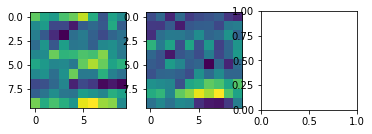

In [19]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
            
"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 10)
visualize_beta(beta_1)
visualize_alpha(alpha_2, 10)
visualize_beta(beta_2)

In [ ]:
logits_init = subnet_output(alpha_1, beta_1, X_)+ subnet_output(alpha_2, beta_2, X_)

In [ ]:
logic = sess.run(logits_init, feed_dict={X_ : [x_test[4]]})
print(np.argmax(logic,axis =1))
print(y_test[4])
#plt.imshow(x_test[4200])

In [ ]:
logic = sess.run(logits_init, feed_dict={X_ : [x_test[4000]]})
print(np.argmax(logic,axis =1))
print(y_test[4000])
#plt.imshow(x_test[4000])

# Sequential Training

In [20]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq




In [21]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [22]:
"""Sequential training"""
batch_size = 250

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(125):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)

train_loss: 0.454951, train_accuracy: 0.493399
test_loss: 0.451328, test_accuracy: 0.506601
train_loss: 0.454537, train_accuracy: 0.493399
test_loss: 0.450925, test_accuracy: 0.506601
train_loss: 0.454345, train_accuracy: 0.493399
test_loss: 0.450750, test_accuracy: 0.506601
train_loss: 0.454200, train_accuracy: 0.493399
test_loss: 0.450627, test_accuracy: 0.506601
train_loss: 0.454059, train_accuracy: 0.493399
test_loss: 0.450510, test_accuracy: 0.506601
train_loss: 0.453910, train_accuracy: 0.493399
test_loss: 0.450387, test_accuracy: 0.506601
train_loss: 0.453753, train_accuracy: 0.493399
test_loss: 0.450258, test_accuracy: 0.506601
train_loss: 0.453587, train_accuracy: 0.493399
test_loss: 0.450121, test_accuracy: 0.506601
train_loss: 0.453413, train_accuracy: 0.493399
test_loss: 0.449978, test_accuracy: 0.506601
train_loss: 0.453230, train_accuracy: 0.493399
test_loss: 0.449828, test_accuracy: 0.506601
train_loss: 0.453040, train_accuracy: 0.493399
test_loss: 0.449672, test_accurac

train_loss: 0.435864, train_accuracy: 0.826733
test_loss: 0.437356, test_accuracy: 0.825082
train_loss: 0.435732, train_accuracy: 0.828383
test_loss: 0.437287, test_accuracy: 0.826733
train_loss: 0.435601, train_accuracy: 0.830033
test_loss: 0.437220, test_accuracy: 0.826733
train_loss: 0.435472, train_accuracy: 0.831683
test_loss: 0.437154, test_accuracy: 0.830033
train_loss: 0.435344, train_accuracy: 0.833333
test_loss: 0.437089, test_accuracy: 0.830033
train_loss: 0.435217, train_accuracy: 0.838284
test_loss: 0.437026, test_accuracy: 0.831683
train_loss: 0.435092, train_accuracy: 0.839934
test_loss: 0.436964, test_accuracy: 0.833333
train_loss: 0.434967, train_accuracy: 0.839934
test_loss: 0.436904, test_accuracy: 0.836634
train_loss: 0.434844, train_accuracy: 0.844885
test_loss: 0.436845, test_accuracy: 0.836634
train_loss: 0.434722, train_accuracy: 0.848185
test_loss: 0.436788, test_accuracy: 0.836634
train_loss: 0.434602, train_accuracy: 0.848185
test_loss: 0.436731, test_accurac

'Sequential training evaluation'

In [23]:
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [24]:
"""Sequential training"""
batch_size = 250

epoch_train_accuracy = []
epoch_test_accuracy = []
t1 = time.time()
#s = s+ (t2-t1)
for epoch in range(500):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_2_seq, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
t2 = time.time()
s = s+ (t2-t1)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")
print(s)
"""Sequential training evaluation"""

train_loss: 0.438455, train_accuracy: 0.818482
test_loss: 0.440444, test_accuracy: 0.810231
train_loss: 0.438367, train_accuracy: 0.821782
test_loss: 0.440413, test_accuracy: 0.811881
train_loss: 0.438280, train_accuracy: 0.823432
test_loss: 0.440382, test_accuracy: 0.815181
train_loss: 0.438194, train_accuracy: 0.825082
test_loss: 0.440352, test_accuracy: 0.815181
train_loss: 0.438108, train_accuracy: 0.825082
test_loss: 0.440323, test_accuracy: 0.815181
train_loss: 0.438023, train_accuracy: 0.826733
test_loss: 0.440295, test_accuracy: 0.818482
train_loss: 0.437938, train_accuracy: 0.828383
test_loss: 0.440267, test_accuracy: 0.818482
train_loss: 0.437855, train_accuracy: 0.830033
test_loss: 0.440240, test_accuracy: 0.820132
train_loss: 0.437772, train_accuracy: 0.830033
test_loss: 0.440214, test_accuracy: 0.823432
train_loss: 0.437689, train_accuracy: 0.833333
test_loss: 0.440188, test_accuracy: 0.825082
train_loss: 0.437607, train_accuracy: 0.834984
test_loss: 0.440163, test_accurac

train_loss: 0.432557, train_accuracy: 0.894389
test_loss: 0.439113, test_accuracy: 0.882838
train_loss: 0.432509, train_accuracy: 0.894389
test_loss: 0.439101, test_accuracy: 0.882838
train_loss: 0.432461, train_accuracy: 0.894389
test_loss: 0.439089, test_accuracy: 0.882838
train_loss: 0.432413, train_accuracy: 0.894389
test_loss: 0.439076, test_accuracy: 0.882838
train_loss: 0.432366, train_accuracy: 0.894389
test_loss: 0.439063, test_accuracy: 0.882838
train_loss: 0.432319, train_accuracy: 0.894389
test_loss: 0.439050, test_accuracy: 0.882838
train_loss: 0.432272, train_accuracy: 0.896040
test_loss: 0.439037, test_accuracy: 0.882838
train_loss: 0.432225, train_accuracy: 0.897690
test_loss: 0.439024, test_accuracy: 0.884488
train_loss: 0.432179, train_accuracy: 0.897690
test_loss: 0.439011, test_accuracy: 0.886139
train_loss: 0.432133, train_accuracy: 0.897690
test_loss: 0.438997, test_accuracy: 0.886139
train_loss: 0.432087, train_accuracy: 0.897690
test_loss: 0.438983, test_accurac

train_loss: 0.428967, train_accuracy: 0.920792
test_loss: 0.437635, test_accuracy: 0.912541
train_loss: 0.428934, train_accuracy: 0.920792
test_loss: 0.437620, test_accuracy: 0.912541
train_loss: 0.428901, train_accuracy: 0.920792
test_loss: 0.437604, test_accuracy: 0.912541
train_loss: 0.428869, train_accuracy: 0.920792
test_loss: 0.437588, test_accuracy: 0.912541
train_loss: 0.428837, train_accuracy: 0.920792
test_loss: 0.437573, test_accuracy: 0.912541
train_loss: 0.428804, train_accuracy: 0.920792
test_loss: 0.437558, test_accuracy: 0.912541
train_loss: 0.428772, train_accuracy: 0.920792
test_loss: 0.437542, test_accuracy: 0.912541
train_loss: 0.428740, train_accuracy: 0.920792
test_loss: 0.437527, test_accuracy: 0.912541
train_loss: 0.428708, train_accuracy: 0.920792
test_loss: 0.437512, test_accuracy: 0.912541
train_loss: 0.428677, train_accuracy: 0.922442
test_loss: 0.437497, test_accuracy: 0.912541
train_loss: 0.428645, train_accuracy: 0.922442
test_loss: 0.437483, test_accurac

train_loss: 0.426385, train_accuracy: 0.935644
test_loss: 0.436770, test_accuracy: 0.917492
train_loss: 0.426360, train_accuracy: 0.935644
test_loss: 0.436767, test_accuracy: 0.917492
train_loss: 0.426335, train_accuracy: 0.935644
test_loss: 0.436764, test_accuracy: 0.917492
train_loss: 0.426311, train_accuracy: 0.935644
test_loss: 0.436761, test_accuracy: 0.917492
train_loss: 0.426286, train_accuracy: 0.935644
test_loss: 0.436758, test_accuracy: 0.915842
train_loss: 0.426262, train_accuracy: 0.935644
test_loss: 0.436755, test_accuracy: 0.915842
train_loss: 0.426238, train_accuracy: 0.935644
test_loss: 0.436753, test_accuracy: 0.915842
train_loss: 0.426213, train_accuracy: 0.935644
test_loss: 0.436750, test_accuracy: 0.915842
train_loss: 0.426189, train_accuracy: 0.935644
test_loss: 0.436748, test_accuracy: 0.915842
train_loss: 0.426165, train_accuracy: 0.935644
test_loss: 0.436746, test_accuracy: 0.915842
train_loss: 0.426141, train_accuracy: 0.935644
test_loss: 0.436743, test_accurac

train_loss: 0.424418, train_accuracy: 0.933993
test_loss: 0.436795, test_accuracy: 0.917492
train_loss: 0.424399, train_accuracy: 0.933993
test_loss: 0.436797, test_accuracy: 0.917492
train_loss: 0.424380, train_accuracy: 0.933993
test_loss: 0.436800, test_accuracy: 0.917492
train_loss: 0.424360, train_accuracy: 0.933993
test_loss: 0.436802, test_accuracy: 0.917492
train_loss: 0.424341, train_accuracy: 0.933993
test_loss: 0.436805, test_accuracy: 0.917492
train_loss: 0.424322, train_accuracy: 0.933993
test_loss: 0.436807, test_accuracy: 0.917492
train_loss: 0.424303, train_accuracy: 0.933993
test_loss: 0.436810, test_accuracy: 0.917492
train_loss: 0.424284, train_accuracy: 0.933993
test_loss: 0.436812, test_accuracy: 0.917492
train_loss: 0.424265, train_accuracy: 0.933993
test_loss: 0.436815, test_accuracy: 0.917492
train_loss: 0.424247, train_accuracy: 0.933993
test_loss: 0.436817, test_accuracy: 0.917492
train_loss: 0.424228, train_accuracy: 0.933993
test_loss: 0.436820, test_accurac

train_loss: 0.422858, train_accuracy: 0.937294
test_loss: 0.437070, test_accuracy: 0.915842
train_loss: 0.422843, train_accuracy: 0.937294
test_loss: 0.437074, test_accuracy: 0.915842
train_loss: 0.422828, train_accuracy: 0.937294
test_loss: 0.437077, test_accuracy: 0.915842
train_loss: 0.422813, train_accuracy: 0.937294
test_loss: 0.437081, test_accuracy: 0.915842
train_loss: 0.422798, train_accuracy: 0.937294
test_loss: 0.437084, test_accuracy: 0.915842
train_loss: 0.422782, train_accuracy: 0.937294
test_loss: 0.437088, test_accuracy: 0.915842
train_loss: 0.422768, train_accuracy: 0.937294
test_loss: 0.437091, test_accuracy: 0.915842
train_loss: 0.422753, train_accuracy: 0.937294
test_loss: 0.437095, test_accuracy: 0.915842
train_loss: 0.422738, train_accuracy: 0.937294
test_loss: 0.437098, test_accuracy: 0.915842
train_loss: 0.422723, train_accuracy: 0.937294
test_loss: 0.437102, test_accuracy: 0.915842
train_loss: 0.422708, train_accuracy: 0.937294
test_loss: 0.437105, test_accurac

'Sequential training evaluation'

In [ ]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [25]:
s/400


0.011558131575584411

In [ ]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
"""Sequential training"""
batch_size = 250

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(40):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_1_seq, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

In [ ]:
logits_ = subnet_output(alpha_1, beta_1, X_) 
logits__ = sess.run(logits_, feed_dict={X: [x_test[4000]]})
print(logits__)
print(np.argmax(logits__))
print(y_test[4000])
plt.imshow(x_test[4000])

In [ ]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
            
"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 10)
visualize_beta(beta_1)
visualize_alpha(alpha_2, 10)
visualize_beta(beta_2)

In [ ]:
sess.run(tf.math.sin(tf.constant([0.9])))